In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.stats.multitest
import tqdm

## Preprocess data

Decide on which two stages to analyze, rename columns so they're human-readable, normalize by column sum

In [57]:
gene_exp_mat = "/exports/home/jolivieri/bowtie2/output/ge.mat"
meta_file = "/exports/home/jolivieri/data/bulk/PRJNA930874/meta.csv"
df = pd.read_csv(gene_exp_mat,sep="\t", index_col = 0)
meta = pd.read_csv(meta_file)

# get runs in this dataframe
SRRs = [x.split("/")[-1].split(".")[0] for x in df.columns]

# get stages corresponding to runs
dict_df = meta[meta["Run"].isin(SRRs)][["Run","stage"]]
run_dict = pd.Series(dict_df.stage.values,index=dict_df.Run).to_dict()




In [58]:
# Find the number of gene counts corresponding to each stage
sum_ser = df.sum().to_frame()
sum_ser["Run"] = [x.split("/")[-1].split(".")[0] for x in sum_ser.index]
sum_ser["stage"] = sum_ser["Run"].map(run_dict)
sum_ser.groupby("stage")[0].mean().sort_values()

stage
 A. thaliana uninucleate microspore              3326362.20
 A. thaliana polarised uninucleate microspore    4045645.00
 A. thaliana tricellular pollen                  4186699.25
 A. thaliana bicellular pollen                   5185501.75
Name: 0, dtype: float64

In [59]:
# Subset to only the two stages with the most gene counts
stages = list(sum_ser.groupby("stage")[0].mean().sort_values()[-2:].index)
# stages = [" A. thaliana bicellular pollen"," A. thaliana tricellular pollen"]

sum_ser[sum_ser["stage"].isin(stages)]["Run"]

output/SRR23387027.sam    SRR23387027
output/SRR23387028.sam    SRR23387028
output/SRR23387031.sam    SRR23387031
output/SRR23387032.sam    SRR23387032
output/SRR23387036.sam    SRR23387036
output/SRR23387037.sam    SRR23387037
output/SRR23387040.sam    SRR23387040
output/SRR23387041.sam    SRR23387041
Name: Run, dtype: object

In [60]:
# Replace column names with names that indicate which condition it's in
sum_ser["num"] = range(sum_ser.shape[0])
sum_ser["stage_sub"] = sum_ser["stage"].str.split(" ").str[3] + "_" + sum_ser["num"].astype(str)
#sum_ser[sum_ser["stage"].isin(stages)]["stage_sub"]

name_dict = sum_ser[sum_ser["stage"].isin(stages)]["stage_sub"].to_dict()
name_dict

{'output/SRR23387027.sam': 'tricellular_0',
 'output/SRR23387028.sam': 'bicellular_1',
 'output/SRR23387031.sam': 'tricellular_4',
 'output/SRR23387032.sam': 'bicellular_5',
 'output/SRR23387036.sam': 'tricellular_9',
 'output/SRR23387037.sam': 'bicellular_10',
 'output/SRR23387040.sam': 'tricellular_13',
 'output/SRR23387041.sam': 'bicellular_14'}

In [61]:
# subset original dataframe to only stages we're interested in, and rename
df = df[name_dict.keys()]
df = df.rename(columns=name_dict)
df.reindex(sorted(df.columns), axis=1)

# Normalize dataframe
norm_df = df/df.sum()
#norm_df = np.log10(norm_df)
norm_df

,tricellular_0,bicellular_1,tricellular_4,bicellular_5,tricellular_9,bicellular_10,tricellular_13,bicellular_14
Geneid,,,,,,,,
AT1G01010,0.000000e+00,2.691679e-05,3.244789e-06,0.000000,0.000000e+00,2.504122e-07,1.587719e-06,1.279539e-06
AT1G01020,0.000000e+00,6.622948e-05,6.083980e-07,0.000017,3.287859e-07,4.432297e-05,0.000000e+00,1.827913e-07
AT1G01030,0.000000e+00,3.736476e-05,5.820340e-05,0.000009,2.663166e-05,7.337079e-05,7.938593e-07,2.193495e-06
AT1G01040,2.540391e-04,1.698237e-04,1.421623e-04,0.000005,2.206153e-04,2.163562e-04,4.425766e-04,1.085780e-04
AT1G01046,9.369199e-06,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
ATMG01370,3.372912e-05,4.072936e-05,2.575551e-05,0.000072,2.824271e-04,2.266231e-04,6.350875e-06,1.043738e-04
ATMG01380,1.873840e-06,0.000000e+00,3.447588e-06,0.000042,1.841201e-05,1.402309e-05,0.000000e+00,1.846192e-05
ATMG01390,2.984759e-04,1.505215e-04,5.597261e-05,0.000273,4.734517e-05,8.218530e-04,3.723200e-04,7.457884e-04


## Perform t test 
For each gene, perform a t test between the two stages

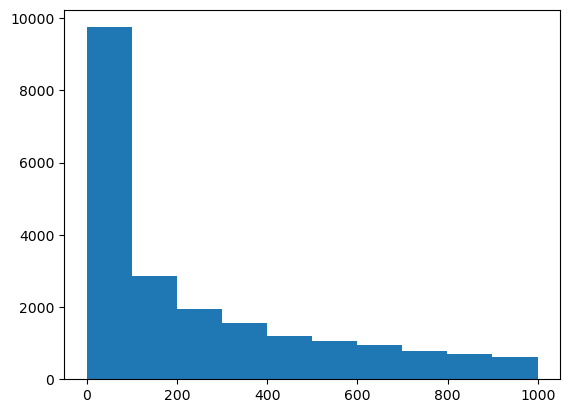

In [110]:
# filter out those with not enough counts (for the sake of multiple hypothesis correction)
gene_counts = df.sum(axis=1)
plt.hist(gene_counts[gene_counts < 1000])
plt.show()

In [113]:
outdict = {"gene": [], "pval": [], "largest" : [], "smallest" : []}
for index, row in tqdm.tqdm(norm_df.loc[gene_counts[gene_counts > 200].index,].iterrows()):
                                            
    # perform t test                                            
    tri = [v for k, v in row.iteritems() if k.startswith("tri")]
    bi = [v for k, v in row.iteritems() if k.startswith("bi")]
    result = sp.stats.ttest_ind(tri, bi)
    
    outdict["gene"].append(index)
    outdict["pval"].append(result.pvalue)
    outdict["largest"].append(row.max())
    outdict["smallest"].append(row.min())


17084it [00:10, 1567.59it/s]


In [114]:
out = pd.DataFrame.from_dict(outdict)
out = out.dropna()
out["pval_adj"] = statsmodels.stats.multitest.multipletests(out["pval"],method="fdr_bh")[1]

In [115]:
out.sort_values("pval")

,gene,pval,largest,smallest,pval_adj
16881,ATCG00420,0.000084,0.000146,3.244789e-06,0.575291
3085,AT1G60505,0.000098,0.000039,0.000000e+00,0.575291
10842,AT4G09140,0.000106,0.000129,0.000000e+00,0.575291
6956,AT2G47470,0.000135,0.000106,1.587719e-06,0.575291
3493,AT1G67280,0.000247,0.000047,3.756184e-06,0.697818
...,...,...,...,...,...
1706,AT1G26190,0.999504,0.000249,3.473034e-06,0.999665
1256,AT1G18630,0.999529,0.000021,0.000000e+00,0.999665
4479,AT2G02360,0.999553,0.000423,0.000000e+00,0.999665
7549,AT3G08950,0.999607,0.000094,3.287859e-07,0.999665


In [128]:
df.loc["AT1G18630"].sort_index()

bicellular_1       67
bicellular_10      82
bicellular_14       0
bicellular_5       42
tricellular_0      65
tricellular_13      2
tricellular_4     104
tricellular_9       3
Name: AT1G18630, dtype: int64

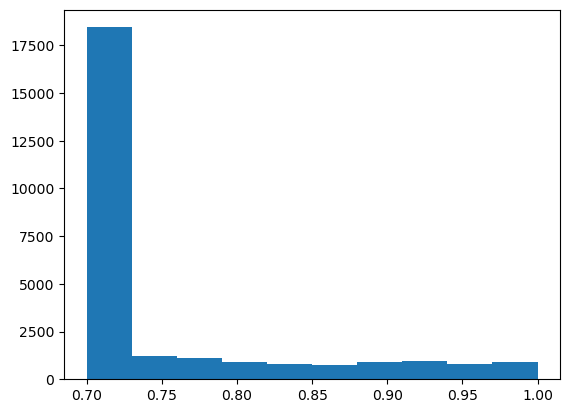

In [100]:
plt.hist(out["pval_adj"])
plt.show()